In [17]:
import numpy as np
import pandas as pd
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.feature import local_binary_pattern, hog
from skimage.filters import gabor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import os

In [1]:
def load_images_from_folder_in_batches(folder, label, image_size, batch_size):
    images = []
    labels = []
    for i, filename in enumerate(os.listdir(folder)):
        if i >= batch_size:
            yield np.array(images), np.array(labels)
            images, labels = [], []
        img_path = os.path.join(folder, filename)
        img = imread(img_path)
        if img.ndim == 3 and img.shape[2] == 4:
            img = img[..., :3]
        if img.ndim == 3:
            img = rgb2gray(img)
        img = np.resize(img, (image_size, image_size))
        images.append(img)
        labels.append(label)
    if images:
        yield np.array(images), np.array(labels)

def preprocess_images(images):
    return images.astype('float32') / 255.0

def extract_histogram_features(images):
    features = []
    for img in images:
        hist, _ = np.histogram(img, bins=256, range=(0, 1))
        features.append(hist)
    return np.array(features)

def extract_edge_density_features(images):
    features = []
    for img in images:
        edges = np.mean(img)
        features.append([edges])
    return np.array(features)

def extract_lbp_features(images):
    features = []
    for img in images:
        lbp = local_binary_pattern(img, P=8, R=1.0, method='uniform')
        hist, _ = np.histogram(lbp, bins=np.arange(0, 11), range=(0, 10))
        features.append(hist)
    return np.array(features)

def extract_hog_features(images):
    features = []
    for img in images:
        hog_feature = hog(img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)
        features.append(hog_feature)
    return np.array(features)

def extract_gabor_features(images):
    features = []
    for img in images:
        filt_real, filt_imag = gabor(img, frequency=0.6)
        features.append(filt_real.ravel())
    return np.array(features)

def extract_features_in_batches(show_dir, ad_break_dir, image_size, batch_size):
    histogram_features, edge_density_features, lbp_features, hog_features, gabor_features, labels = [], [], [], [], [], []
    
    # Process 'show' directory
    for images, label_batch in load_images_from_folder_in_batches(show_dir, 0, image_size, batch_size):
        images = preprocess_images(images)
        histogram_features.append(extract_histogram_features(images))
        edge_density_features.append(extract_edge_density_features(images))
        lbp_features.append(extract_lbp_features(images))
        hog_features.append(extract_hog_features(images))
        gabor_features.append(extract_gabor_features(images))
        labels.append(label_batch)
    
    # Process 'ad_break' directory
    for images, label_batch in load_images_from_folder_in_batches(ad_break_dir, 1, image_size, batch_size):
        images = preprocess_images(images)
        histogram_features.append(extract_histogram_features(images))
        edge_density_features.append(extract_edge_density_features(images))
        lbp_features.append(extract_lbp_features(images))
        hog_features.append(extract_hog_features(images))
        gabor_features.append(extract_gabor_features(images))
        labels.append(label_batch)
    
    # Combine all features and labels
    histogram_features = np.vstack(histogram_features)
    edge_density_features = np.vstack(edge_density_features)
    lbp_features = np.vstack(lbp_features)
    hog_features = np.vstack(hog_features)
    gabor_features = np.vstack(gabor_features)
    labels = np.hstack(labels)
    
    return histogram_features, edge_density_features, lbp_features, hog_features, gabor_features, labels

# Define paths
show_dir = r'C:\Users\Administrator\Downloads\data\show\show'
ad_break_dir = r'C:\Users\Administrator\Downloads\data\Ad_break\Ad_break'

# Parameters
image_size = 128
batch_size = 10  # Decrease batch size further to prevent MemoryError

# Extract features and labels
histogram_features, edge_density_features, lbp_features, hog_features, gabor_features, labels = extract_features_in_batches(show_dir, ad_break_dir, image_size, batch_size)

# Combine all features into a single dataframe
combined_features = np.hstack([histogram_features, edge_density_features, lbp_features, gabor_features, hog_features])
combined_features_df = pd.DataFrame(combined_features)
combined_features_df['label'] = labels

# Save the combined features to CSV
combined_features_df.to_csv('combined_features.csv', index=False)


C:\Users\Administrator\anaconda3\Lib\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Skipping chunk with only one class.
Skipping chunk with only one class.
Skipping chunk with only one class.
Skipping chunk with only one class.
Skipping chunk with only one class.
Skipping chunk with only one class.
Skipping chunk with only one class.
Skipping chunk with only one class.
Skipping chunk with only one class.
Skipping chunk with only one class.
Skipping chunk with only one class.
Skipping chunk with only one class.
Skipping chunk with only one class.
Skipping chunk with only one class.
Skipping chunk with only one class.
Skipping chunk with only one class.
Skipping chunk with only one class.
Skipping chunk with only one class.
Skipping chunk with only one class.
Skipping chunk with only one class.
Skipping chunk with only one class.
Skipping chunk with only one class.
Skipping chunk with only one class.
Skipping chunk with only one class.
Skipping chunk with only one class.
Skipping chunk with only one class.
Skipping chunk with only one class.
Skipping chunk with only one

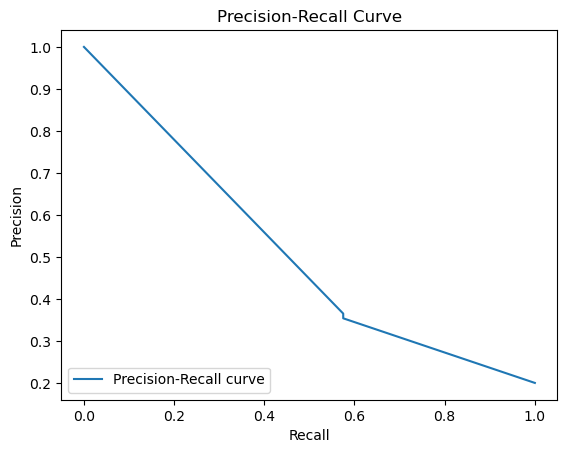

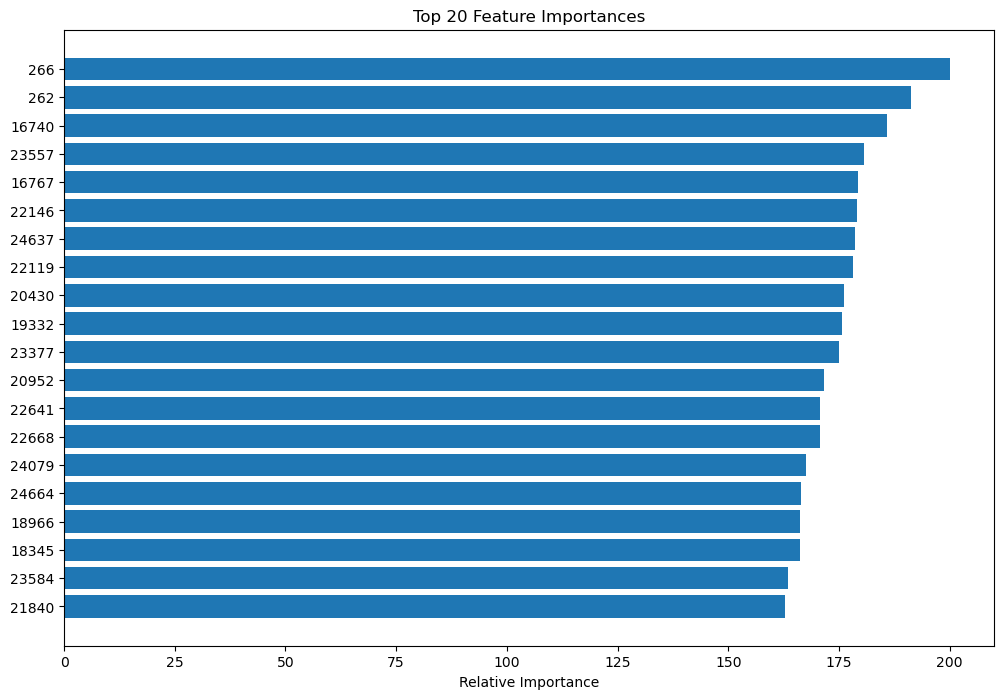

In [15]:
# Define the chunk size
chunk_size = 1000  # Adjust chunk size if needed

# Initialize the SGDClassifier with partial_fit
sgd_model = SGDClassifier(loss='log_loss', random_state=42)
scaler = StandardScaler()

# Define the file path for the combined features CSV
file_path = 'combined_features.csv'

# Initialize variables to store the evaluation results
all_y_test = []
all_y_pred = []
all_y_pred_proba = []

# Define the classes (assuming binary classification with labels 0 and 1)
classes = np.array([0, 1])

# Read and process the data in chunks
data_iter = pd.read_csv(file_path, chunksize=chunk_size)

for chunk in data_iter:
    # Split the chunk into features (X) and labels (y)
    X_chunk = chunk.drop(columns=['label'])
    y_chunk = chunk['label']

    # Check if the chunk contains both classes
    if len(np.unique(y_chunk)) < 2:
        print("Skipping chunk with only one class.")
        continue

    # Standardize the chunk
    X_chunk = scaler.fit_transform(X_chunk)

    # Stratified split to ensure both training and validation sets have both classes
    X_train_chunk, X_test_chunk, y_train_chunk, y_test_chunk = train_test_split(X_chunk, y_chunk, test_size=0.2, random_state=42, stratify=y_chunk)

    try:
        # Incrementally fit the model with partial_fit
        sgd_model.partial_fit(X_train_chunk, y_train_chunk, classes=classes)

        # Predict on the test chunk and store the results
        y_pred_chunk = sgd_model.predict(X_test_chunk)
        y_pred_proba_chunk = sgd_model.predict_proba(X_test_chunk)[:, 1]

        all_y_test.extend(y_test_chunk)
        all_y_pred.extend(y_pred_chunk)
        all_y_pred_proba.extend(y_pred_proba_chunk)
    except ValueError as e:
        if "classes has to be greater than one" in str(e):
            # Skip chunks with only one class
            print("Skipping chunk with only one class.")
            continue
        else:
            raise e

# Convert lists to numpy arrays for evaluation
all_y_test = np.array(all_y_test)
all_y_pred = np.array(all_y_pred)
all_y_pred_proba = np.array(all_y_pred_proba)

# Save the trained model
joblib.dump(sgd_model, 'sgd_model.pkl')

# Evaluate the model on the accumulated test data
accuracy = np.mean(all_y_test == all_y_pred)
conf_matrix = confusion_matrix(all_y_test, all_y_pred)
class_report = classification_report(all_y_test, all_y_pred)

# Print evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(all_y_test, all_y_pred_proba)
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# Feature Importance Visualization
importances = np.abs(sgd_model.coef_[0])
indices = np.argsort(importances)[-20:]  # Top 20 features
plt.figure(figsize=(12, 8))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), indices)
plt.xlabel('Relative Importance')
plt.title('Top 20 Feature Importances')
plt.show()


Skipping chunk with only one class.
Skipping chunk with only one class.
Skipping chunk with only one class.
Skipping chunk with only one class.
Skipping chunk with only one class.
Skipping chunk with only one class.
Skipping chunk with only one class.
Skipping chunk with only one class.
Skipping chunk with only one class.
Skipping chunk with only one class.
Skipping chunk with only one class.
Skipping chunk with only one class.
Skipping chunk with only one class.
Skipping chunk with only one class.
Skipping chunk with only one class.
Skipping chunk with only one class.
Skipping chunk with only one class.
Skipping chunk with only one class.
Skipping chunk with only one class.
Skipping chunk with only one class.
Skipping chunk with only one class.
Skipping chunk with only one class.
Skipping chunk with only one class.
Skipping chunk with only one class.
Skipping chunk with only one class.
Skipping chunk with only one class.
Skipping chunk with only one class.
Skipping chunk with only one

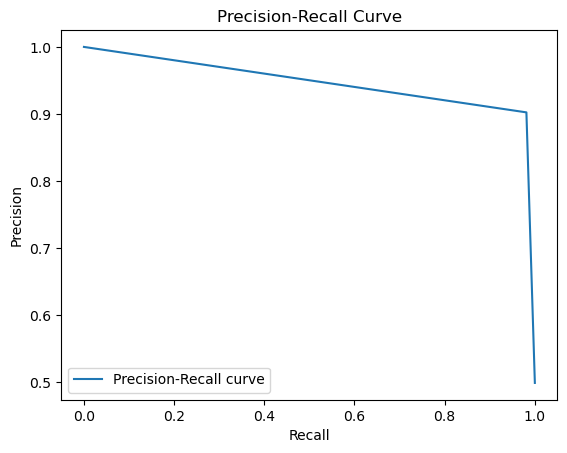

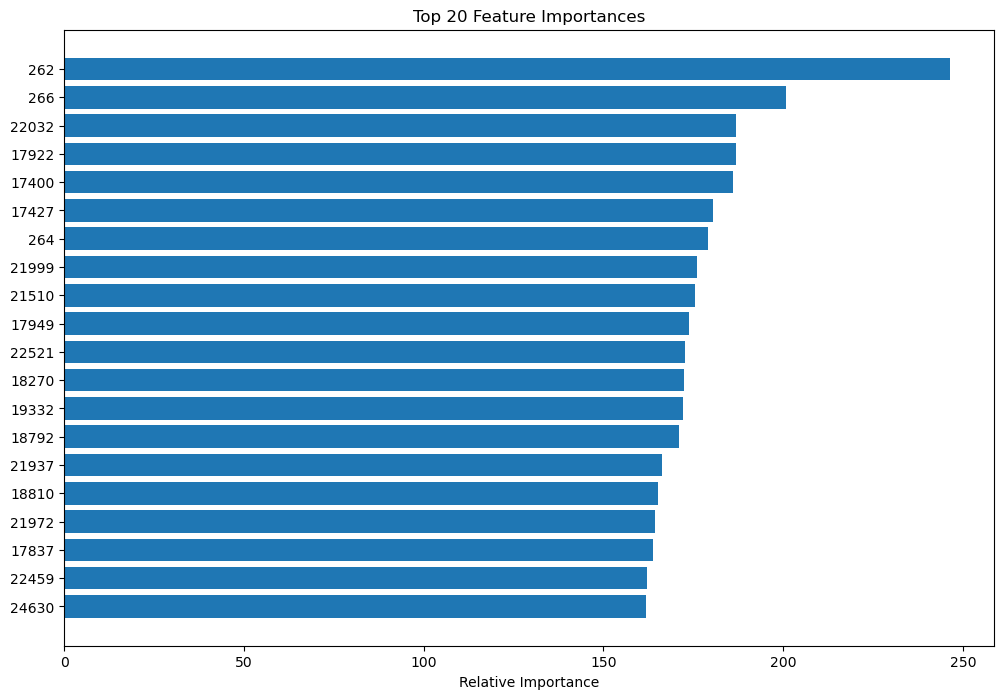

In [17]:
# Define the chunk size
chunk_size = 1000  # Adjust chunk size if needed

# Initialize the SGDClassifier with partial_fit
sgd_model = SGDClassifier(loss='log_loss', random_state=42)
scaler = StandardScaler()

# Define the file path for the combined features CSV
file_path = 'combined_features.csv'

# Initialize variables to store the evaluation results
all_y_test = np.array([])
all_y_pred = np.array([])
all_y_pred_proba = np.array([])

# Initialize SMOTE for oversampling
smote = SMOTE(random_state=42)

# Read and process the data in chunks
data_iter = pd.read_csv(file_path, chunksize=chunk_size)

for chunk in data_iter:
    # Split the chunk into features (X) and labels (y)
    X_chunk = chunk.drop(columns=['label'])
    y_chunk = chunk['label']

    # Check if the chunk contains both classes
    if len(np.unique(y_chunk)) < 2:
        print("Skipping chunk with only one class.")
        continue

    # Standardize the chunk
    X_chunk = scaler.fit_transform(X_chunk)

    # Apply SMOTE to balance the classes
    X_chunk_res, y_chunk_res = smote.fit_resample(X_chunk, y_chunk)

    # Stratified split to ensure both training and validation sets have both classes
    X_train_chunk, X_test_chunk, y_train_chunk, y_test_chunk = train_test_split(X_chunk_res, y_chunk_res, test_size=0.2, random_state=42, stratify=y_chunk_res)

    try:
        # Incrementally fit the model with partial_fit
        sgd_model.partial_fit(X_train_chunk, y_train_chunk, classes=classes)

        # Predict on the test chunk and store the results
        y_pred_chunk = sgd_model.predict(X_test_chunk)
        y_pred_proba_chunk = sgd_model.predict_proba(X_test_chunk)[:, 1]

        all_y_test = np.concatenate((all_y_test, y_test_chunk))
        all_y_pred = np.concatenate((all_y_pred, y_pred_chunk))
        all_y_pred_proba = np.concatenate((all_y_pred_proba, y_pred_proba_chunk))
    except ValueError as e:
        if "classes has to be greater than one" in str(e):
            # Skip chunks with only one class
            print("Skipping chunk with only one class.")
            continue
        else:
            raise e

# Save the trained model
joblib.dump(sgd_model, 'sgd_model.pkl')

# Evaluate the model on the accumulated test data
accuracy = np.mean(all_y_test == all_y_pred)
conf_matrix = confusion_matrix(all_y_test, all_y_pred)
class_report = classification_report(all_y_test, all_y_pred)

# Print evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(all_y_test, all_y_pred_proba)
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# Feature Importance Visualization
importances = np.abs(sgd_model.coef_[0])
indices = np.argsort(importances)[-20:]  # Top 20 features
plt.figure(figsize=(12, 8))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), indices)
plt.xlabel('Relative Importance')
plt.title('Top 20 Feature Importances')
plt.show()
